Duplicate key in file WindowsPath('d:/Anaconda/envs/python38/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  serif')
C:\Users\wyx\AppData\Local\Temp/ipykernel_16796/1681365469.py:43: RuntimeWarning: covariance is not positive-semidefinite.
  Ns.append(np.random.multivariate_normal(mus[i], sigmas[i], size=size))


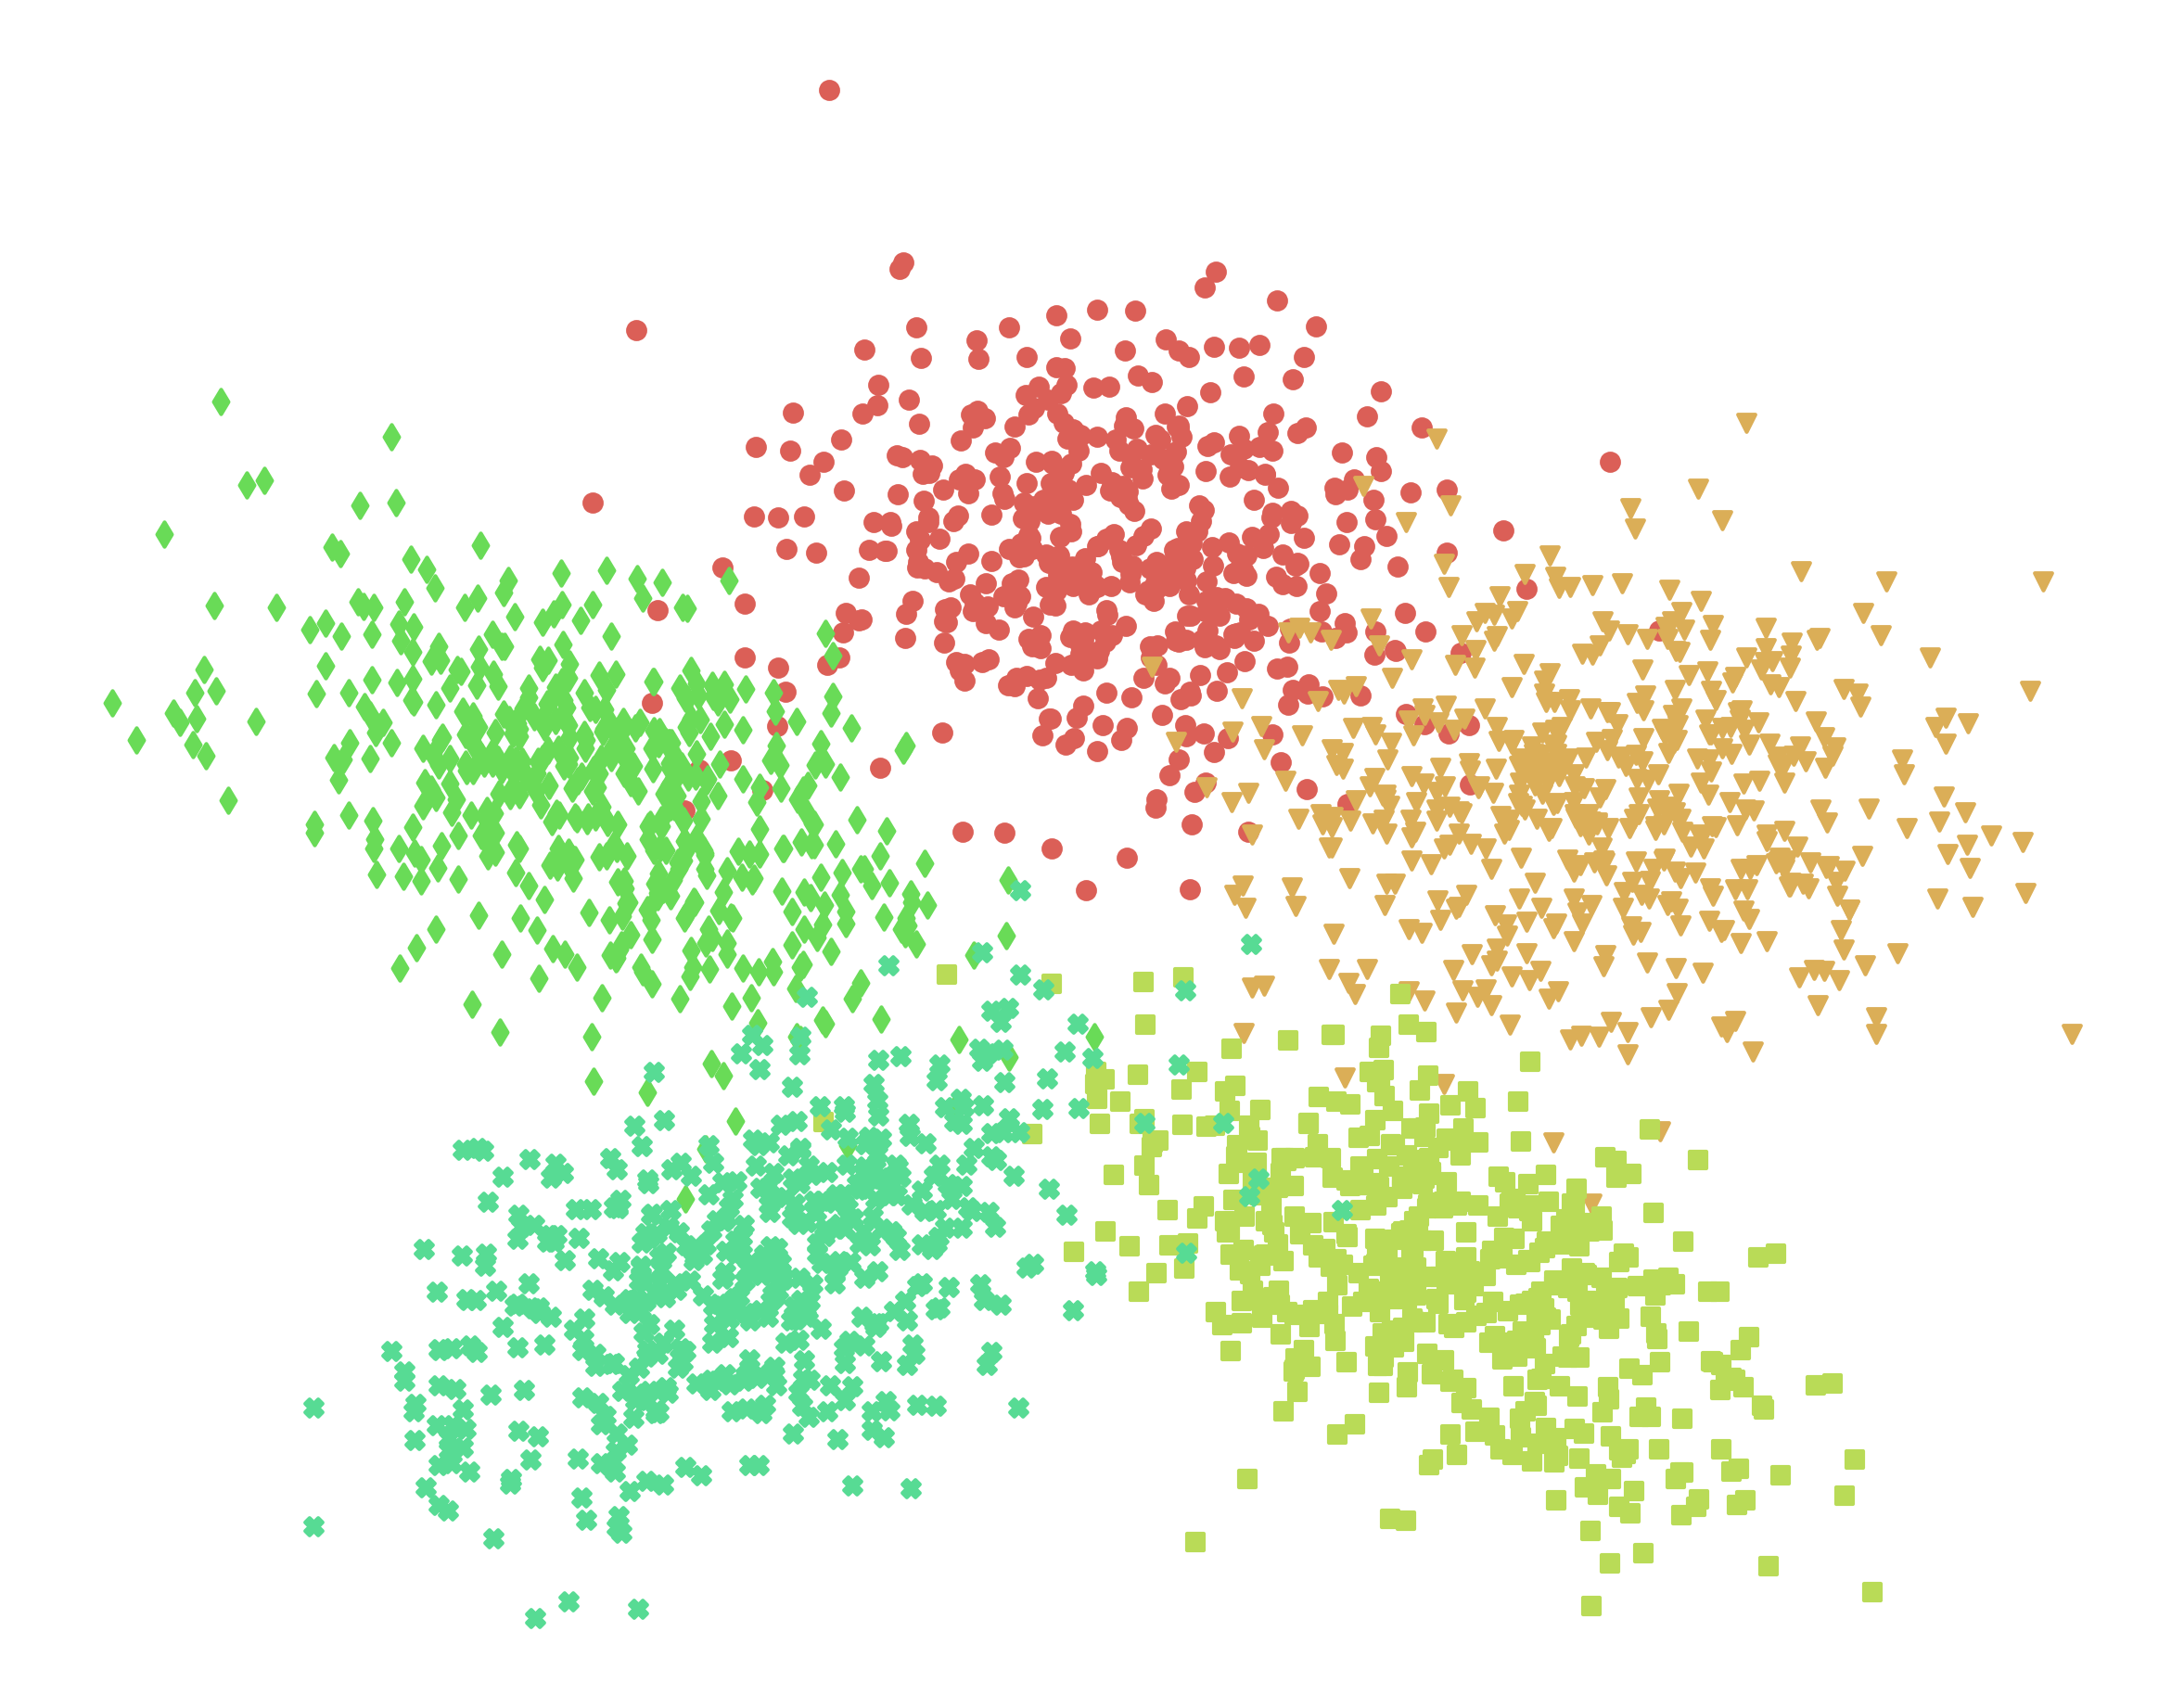

In [1]:
# 模拟选择样本
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import numpy as np 
#import scienceplots
plt.style.use('science')

import seaborn as sns
palette = sns.color_palette('hls', 10)

font = {'family' : 'Times New Roman',
       'weight' : 'regular',
       'size'   : 10}
matplotlib.rc('font', **font)

np.random.seed(1)
size = 500
dc = 0.05
s_num = 100
# 生成5个二维高斯分布N
mus = np.array([[0, 5], 
                [3, 3], 
                [2,-1], 
                [-3, 3], 
                [-2, -1]]) 
sigmas = np.array([[[1, 0], 
                    [0, 1]],
                   [[0, 1], 
                    [1, 0]],
                   [[0.5, -1], 
                    [-1, 0.5]],
                   [[0.5, -1], 
                    [-1, 0.5]],
                   [[1, 0.5], 
                    [0.5, 1]]])  # 协方差矩阵


Ns = []
for i in range(5):
    Ns.append(np.random.multivariate_normal(mus[i], sigmas[i], size=size))
plt.figure(figsize=(10,8),dpi=300)
# 绘制散布图
shape_size = 20
markers = ["o","v","s","d","X"]

p = plt.scatter(Ns[0][:, 0], Ns[0][:, 1], marker=markers[0], s=20, alpha=1, color=palette[0])
color0 = p.get_facecolor()
p = plt.scatter(Ns[1][:, 0], Ns[1][:, 1], marker=markers[1], s=20, alpha=1, color=palette[1])
color1 = p.get_facecolor()
p = plt.scatter(Ns[2][:, 0], Ns[2][:, 1], marker=markers[2], s=20, alpha=1, color=palette[2])
color2 = p.get_facecolor()
p = plt.scatter(Ns[3][:, 0], Ns[3][:, 1], marker=markers[3], s=20, alpha=1, color=palette[3])
color3 = p.get_facecolor()
p = plt.scatter(Ns[4][:, 0], Ns[4][:, 1], marker=markers[4], s=20, alpha=1, color=palette[4])
color4 = p.get_facecolor()
#plt.grid(linestyle="--", alpha=0.5)
#plt.xlabel(r'$x_1$')
#plt.ylabel(r'$x_2$')
#plt.title('Random sampling from 5 Gaussian distributions')

plt.xticks([])
plt.yticks([])
ax=plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# 显示图像
plt.savefig("2d-normdist.pdf", dpi=300)
plt.show()




(2500, 2)
Distance matrix dimension:  torch.Size([2500, 2500])
Average rho value:  82.9184


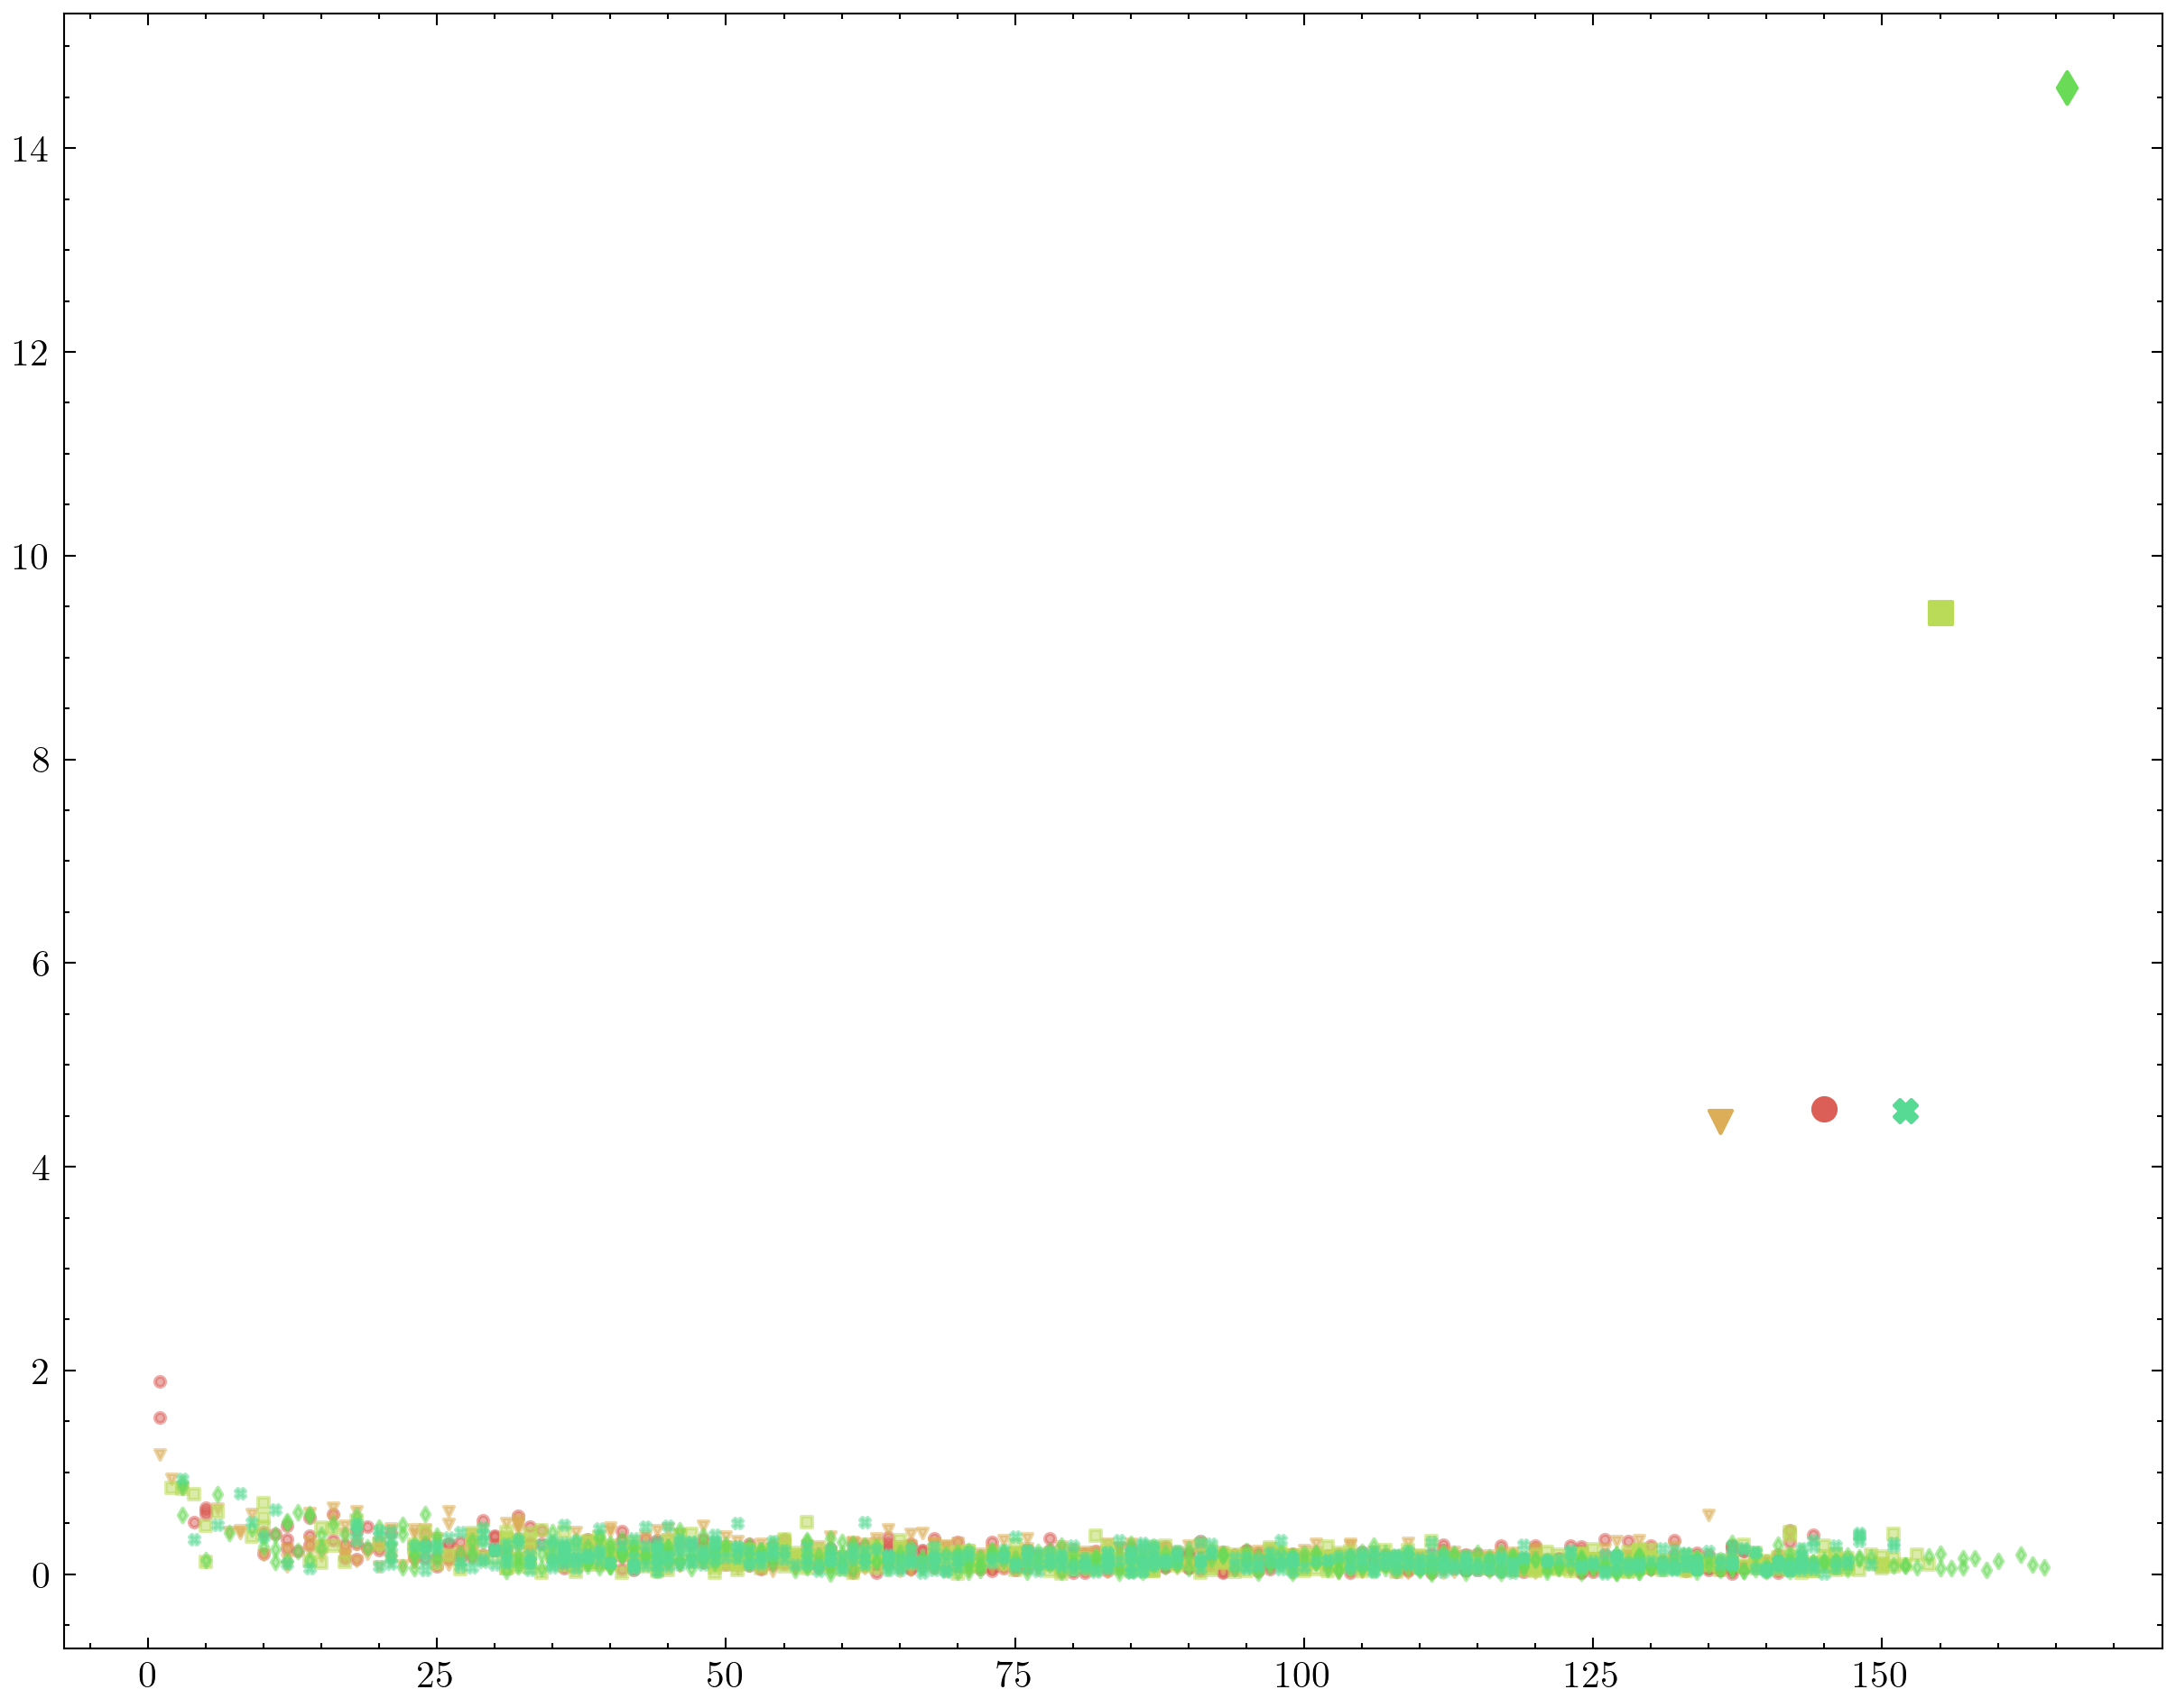

In [3]:

Y = np.zeros(size*5)
Y[:size] = 0
Y[size:2*size] = 1
Y[2*size:3*size] = 2
Y[3*size:4*size] = 3
Y[4*size:] = 4
NN = np.vstack(Ns)
print(NN.shape)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dist_mat = None
rho = [0] * len(Y)
delta = [0] * len(Y)

def compute_distmat():
    global dist_mat
    f_mat = NN
    # 放入显存再计算距离
    # 可能引起显存溢出问题
    #f_mat = torch.tensor(f_mat).to(DEVICE)
    f_mat = torch.tensor(f_mat)
    dist_mat = torch.cdist(f_mat, f_mat, p=1)
    print("Distance matrix dimension: ", dist_mat.shape)
    
def compute_rho():
    global rho
    global dc
    max_dist = torch.max(dist_mat).data.item()
    real_dc = dc * max_dist
    for i in range(len(Y)):
        dist_vec = dist_mat[i]
        rho[i] = torch.sum(torch.where(dist_vec<real_dc,1,0)).data.item()
    print("Average rho value: ", np.sum(rho) / len(rho))

def compute_delta():
    global delta
    for i in range(len(Y)):
        # 当前样本(id)的距离向量
        dist_vec = dist_mat[i]
        # 当前样本的密度
        c_rho = rho[i]
        # 获得距离向量参数排序下标
        dist_sort_indx = torch.argsort(dist_vec).cpu().numpy().astype(np.int32)
        for ind in dist_sort_indx:
            if rho[ind] > c_rho:
                delta[i] = dist_vec[ind]
                break
            
        if delta[i] == 0:
            delta[i] = torch.max(dist_vec).data.item()

compute_distmat()
compute_rho()
compute_delta()

plt.figure(figsize=(10,8), dpi=300)
colors = [color0,color1,color2,color3,color4]
rho_delta = np.asarray(rho) * np.asarray(delta)
indx = np.argsort(rho_delta)[-5:]

for i in range(5):
    plt.scatter(rho[size*i:size*(i+1)], delta[size*i:size*(i+1)], marker=markers[i], s=7, alpha=0.5,color=colors[i][:3])
    
cc = [int(i) for i in Y[indx]]
colors = np.asarray(colors)

for i in range(5):
    plt.scatter(rho[indx[i]], delta[indx[i]], alpha=1, marker=markers[int(Y[indx[i]])], color=colors[int(Y[indx[i]])][:3])

#plt.xlabel(r'$\rho$')
#plt.ylabel(r'$\delta$')
#plt.title(r'$\rho$ and $\delta$ distribution')
# plt.xticks([])
# plt.yticks([])
# ax=plt.gca()
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
plt.savefig("rho-delta.pdf",dpi=300)
plt.show()


In [ ]:

# 模拟分类概率
probs = np.zeros((len(Y), 5))
def compute_probs():
    global probs
    for i in range(len(Y)):
        c_x = NN[i]
        #p = np.zeros(5)
        # for j in range(5):
        #     mat = np.matrix(c_x - mus[j])
        #     c = -0.5 * np.matmul(np.matmul(mat, np.linalg.inv(sigmas[j])), mat.transpose())
        #     p[j] = 1 / (2*np.pi) * np.linalg.det(sigmas[j])**(-0.5) * np.exp(c)
        
        # 用到中心的距离近似概率，距离越小，概率越大
        dist_to_centers = np.zeros(5)
        for j in range(5):
            dist_to_centers[j] = 1/(np.sqrt((c_x[0] - mus[j][0])**2 + (c_x[1] - mus[j][1])**2))
        probs[i] = dist_to_centers
compute_probs()

from scipy.special import softmax

probs = softmax(probs, axis=-1)
print(probs)


In [ ]:
# 只根据rho delta来选择样本
def minmax_normalize(a):
    return (a - np.min(a)) / (np.max(a) - np.min(a))

#info_scores = uncertainty * rho_delta
info_scores = minmax_normalize(rho_delta)

ss = np.ones(5*size).astype(np.int32) * 20

indx = np.argsort(info_scores)[-s_num:]
ss[indx] = 40
plt.figure(figsize=(10,8),dpi=300)
# 绘制散布图
for i in range(5*size):
    #alpha = 1 if ss[i] == 30 else info_scores[i]
    alpha = 1 if ss[i] == 40 else 0.2
    plt.scatter(Ns[i//size][i%size, 0], Ns[i//size][i%size, 1], color=colors[i//size], marker=markers[i//size], s=ss[i], alpha=alpha)
    if i % 100 == 0:
        print("\r{}".format(i),end="")
#plt.grid(linestyle="--", alpha=0.5)
#plt.xlabel(r'$x_1$')
#plt.ylabel(r'$x_2$')
#plt.title(r'Selecting samples by $\tau$')
plt.xticks([])
plt.yticks([])
ax=plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.savefig("s-tau.pdf",dpi=300)
plt.show()


In [ ]:
# 只根据不确定性来选择样本
uncertainty = np.sum(-probs * np.log(probs), axis=-1)
print(uncertainty)

def minmax_normalize(a):
    return (a - np.min(a)) / (np.max(a) - np.min(a))

#info_scores = uncertainty * rho_delta
info_scores = minmax_normalize(uncertainty)

indx = np.argsort(info_scores)[-s_num:]

ss = np.ones(5*size).astype(np.int32) * 20
ss[indx] = 40
plt.figure(figsize=(10,8),dpi=300)
# 绘制散布图
for i in range(5*size):
    #alpha = 1 if ss[i] == 30 else info_scores[i]
    alpha = 1 if ss[i] == 40 else 0.2
    plt.scatter(Ns[i//size][i%size, 0], Ns[i//size][i%size, 1], color=colors[i//size], marker=markers[i//size], s=ss[i], alpha=alpha)
    if i % 100 == 0:
        print("\r{}".format(i),end="")
#plt.grid(linestyle="--", alpha=0.5)
#plt.xlabel(r'$x_1$')
#plt.ylabel(r'$x_2$')
#plt.title(r'Selecting samples by Entropy')
plt.xticks([])
plt.yticks([])
ax=plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.savefig("s-entropy.pdf",dpi=300)
plt.show()


100
2400

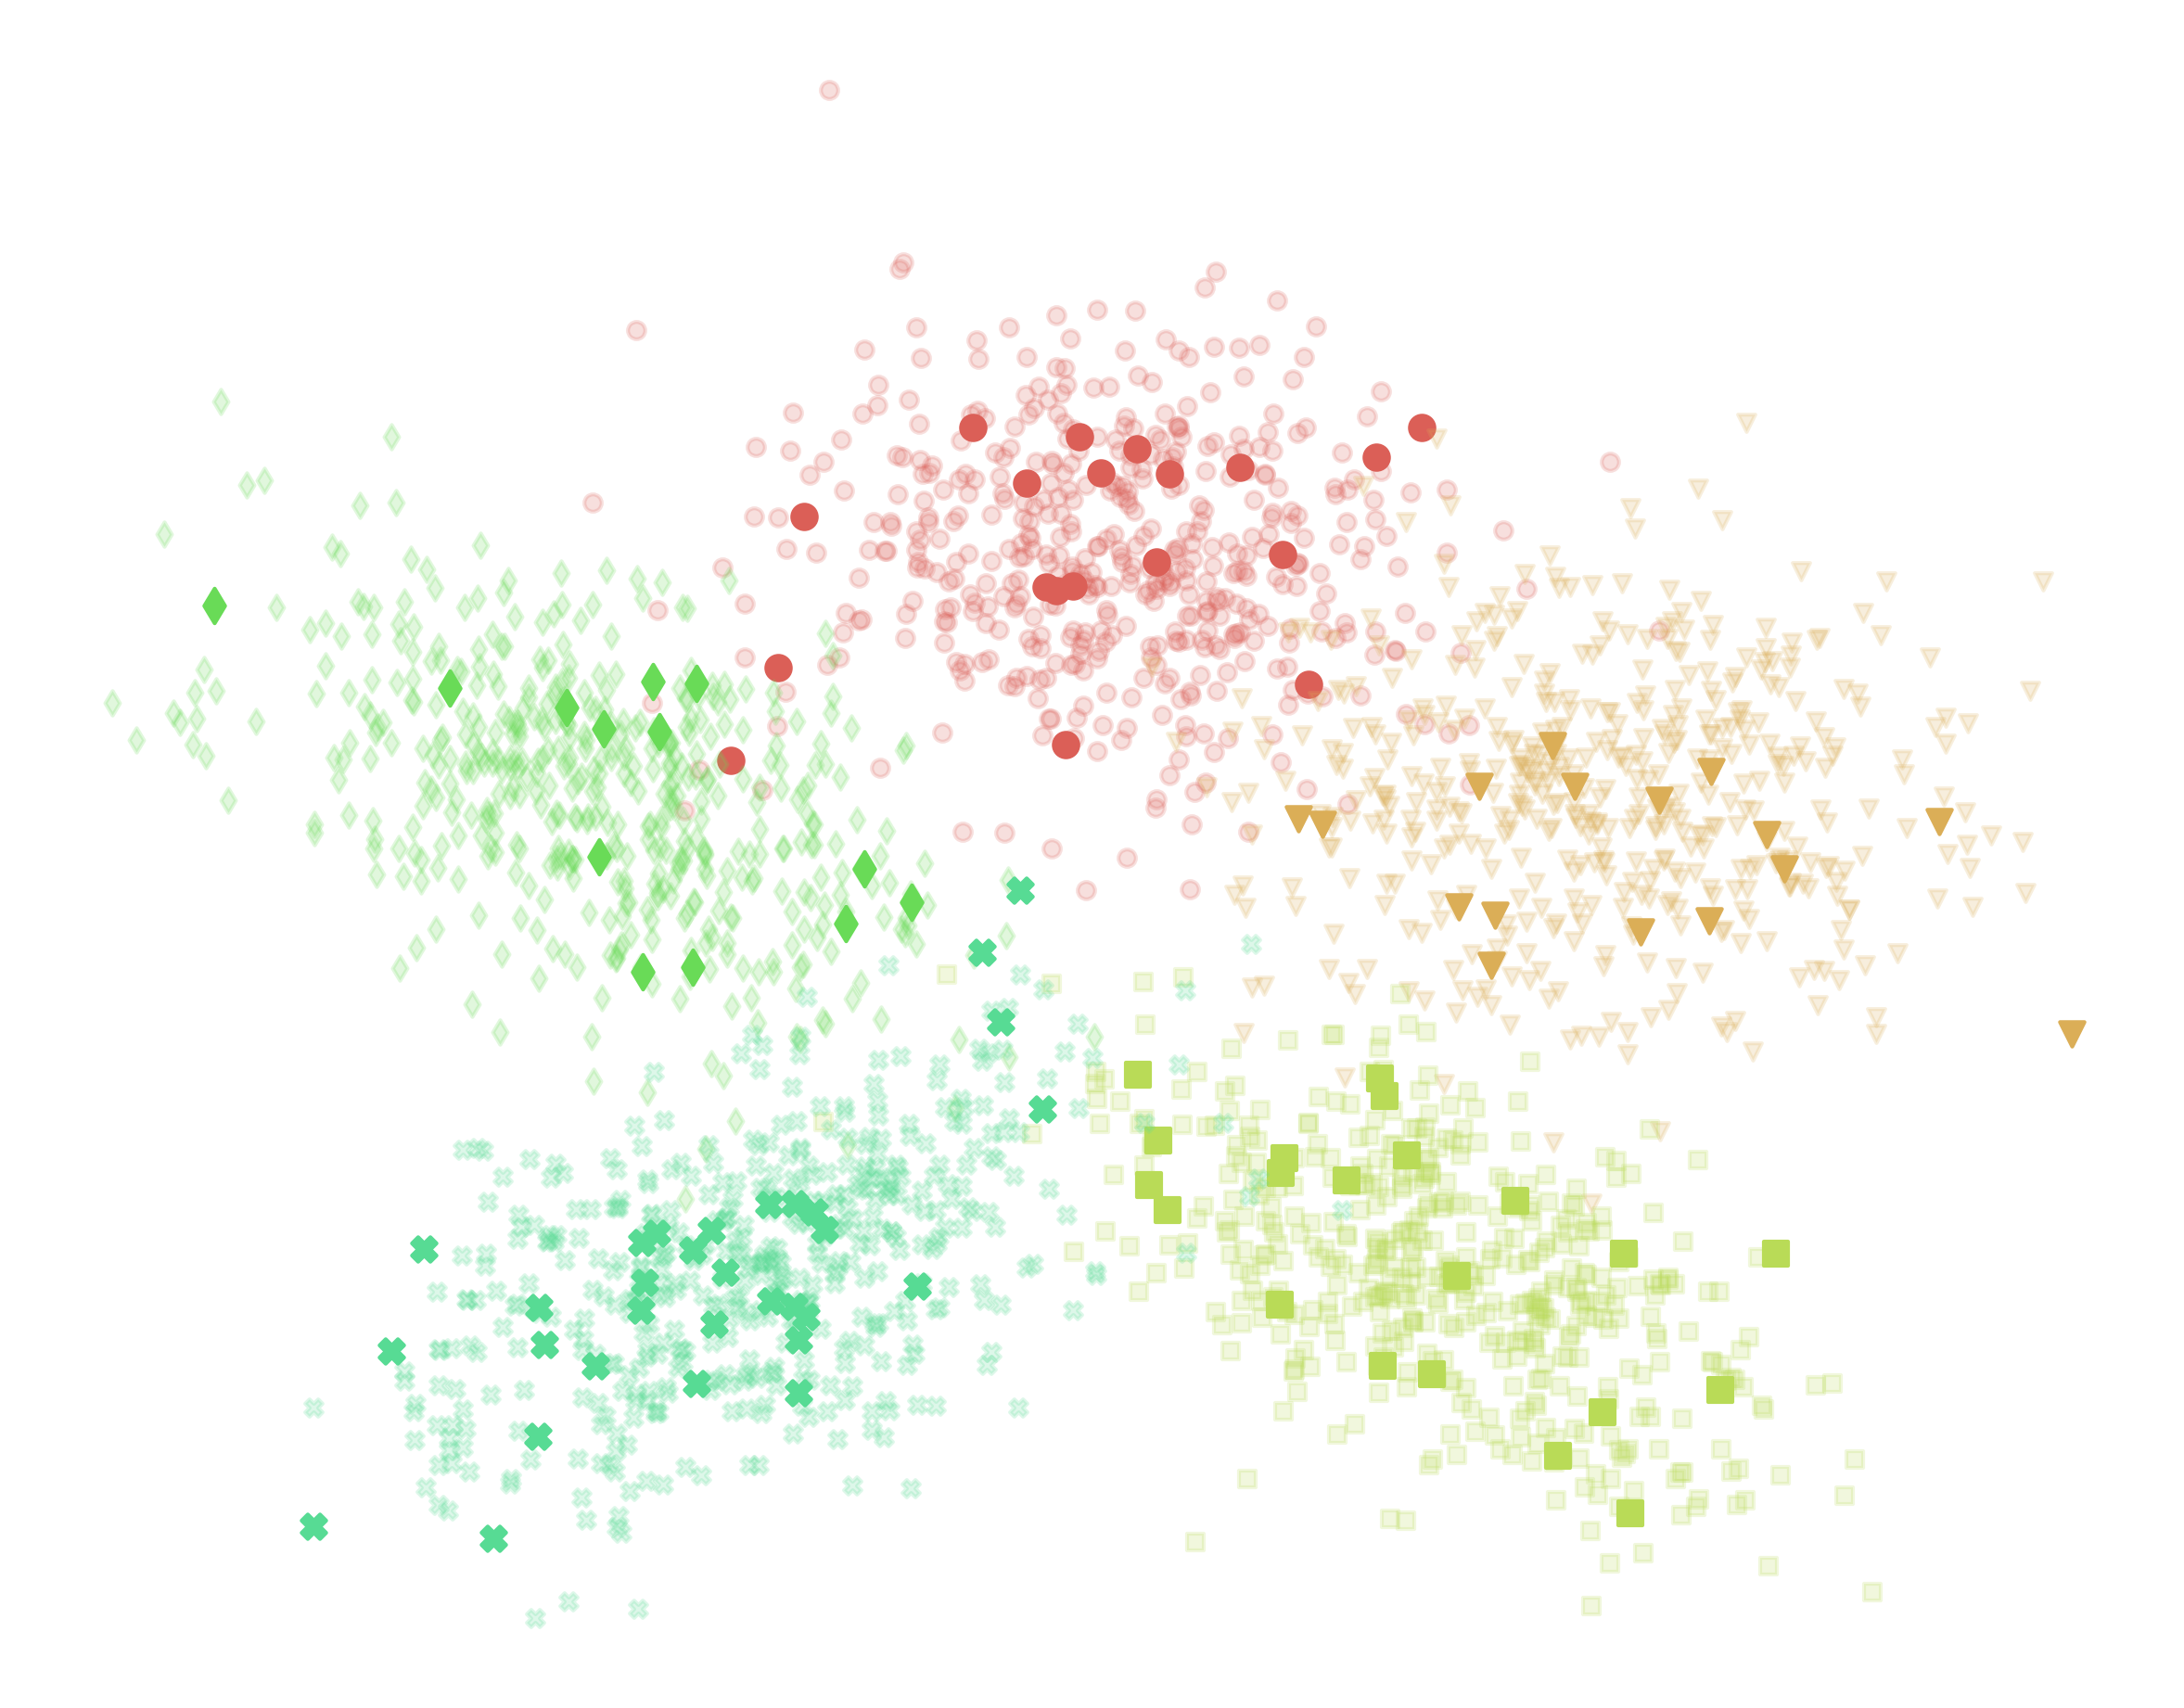

In [5]:
# 随机选择
import numpy as np
indx = np.asarray([i for i in range(5*size)])
np.random.shuffle(indx)
indx = indx[:s_num]

ss = np.ones(5*size).astype(np.int32) * 20
ss[indx] = 40
plt.figure(figsize=(10,8),dpi=300)
# 绘制散布图
print(s_num)
for i in range(5*size):
    #alpha = 1 if ss[i] == 30 else info_scores[i]
    alpha = 1 if ss[i] == 40 else 0.2
    plt.scatter(Ns[i//size][i%size, 0], Ns[i//size][i%size, 1], color=colors[i//size], marker=markers[i//size], s=ss[i], alpha=alpha)
    if i % 100 == 0:
        print("\r{}".format(i),end="")
#plt.grid(linestyle="--", alpha=0.5)
#plt.xlabel(r'$x_1$')
#plt.ylabel(r'$x_2$')
#plt.title(r'Selecting samples by Entropy')
plt.xticks([])
plt.yticks([])
ax=plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.savefig("s-random.pdf",dpi=300)
plt.show()


In [ ]:

# 根据不确定性和rho delta同时选择样本
uncertainty = np.sum(-probs * np.log(probs), axis=-1)
print(uncertainty)

def minmax_normalize(a):
    return (a - np.min(a)) / (np.max(a) - np.min(a))

info_scores = uncertainty * rho_delta
# 极差归一化
info_scores = minmax_normalize(info_scores)

plt.figure(figsize=(10,8),dpi=300)
# 绘制散布图

# 调整选择点和未选择点的尺寸大小
ss = np.ones(5*size).astype(np.int32) * 20

indx = np.argsort(info_scores)[-s_num:]
ss[indx] = 40

for i in range(5*size):
    #alpha = 1 if ss[i] == 30 else info_scores[i]
    alpha = 1 if ss[i] == 40 else 0.2
    plt.scatter(Ns[i//size][i%size, 0], Ns[i//size][i%size, 1], color=colors[i//size], marker=markers[i//size], s=ss[i], alpha=alpha)
    if i % 100 == 0:
        print("\r{}".format(i),end="")


#plt.grid(linestyle="--", alpha=0.5)
#plt.xlabel(r'$x_1$')
#plt.ylabel(r'$x_2$')

plt.xticks([])
plt.yticks([])
ax=plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.savefig("s-umf.pdf",dpi=300)
plt.show()
